# 4. Eco-evolutionary model of an island

A simple example showcasing how to simulate eco-evolutionary patterns on an island by using AdaScape and FastScape.

In [1]:
import numpy as np
import extra_func as ext
import matplotlib.pyplot as plt
%load_ext xsimlab.ipython
from fastscape.models import basic_model
from fastscape.processes import Flexure
from adascape.fastscape_ext import IR12Speciation, FastscapeElevationTrait, CompoundEnvironment, ElevationEnvField, RandomSeedFederation
import xarray as xr

First, we define the processes to include in an **adascape_model**. The aim is to characterize an island that rifted apart from a continent in which the topography is uniform and thus only affected by [isostatic flexure](https://fastscape.readthedocs.io/en/latest/processes.html#isostasy) and organisms only respond to the elevation gradient. 

In [2]:
adascape_model = basic_model.update_processes(
    {'life': IR12Speciation,
     'trait_elev': FastscapeElevationTrait,
     'life_env': CompoundEnvironment,
     'elev_field': ElevationEnvField,
     'random': RandomSeedFederation}
)
adascape_model=adascape_model.update_processes({'flexure': Flexure}).drop_processes({'init_topography'})
adascape_model

<xsimlab.Model (21 processes, 38 inputs)>
grid
    shape                [in] ('shape_yx',) nb. of grid nodes in (y...
    length               [in] ('shape_yx',) total grid length in (y...
boundary
    status               [in] () or ('border',) node status at borders
fs_context
uplift
    rate                 [in] () or ('y', 'x') uplift rate
tectonics
surf2erode
init_erosion
flow
drainage
spl
    k_coef               [in] () or ('y', 'x') bedrock channel inci...
    area_exp             [in] drainage area exponent
    slope_exp            [in] slope exponent
    tol_rel              [in] relative tolerance (Gauss-Siedel conv...
    tol_abs              [in] absolute tolerance (Gauss-Siedel conv...
    max_iter             [in] max nb. of iterations (Gauss-Siedel c...
diffusion
    diffusivity          [in] () or ('y', 'x') diffusivity (transpo...
erosion
flexure
    lithos_density       [in] () or ('y', 'x') lithospheric rock de...
    asthen_density       [in] asthenospheric rock de

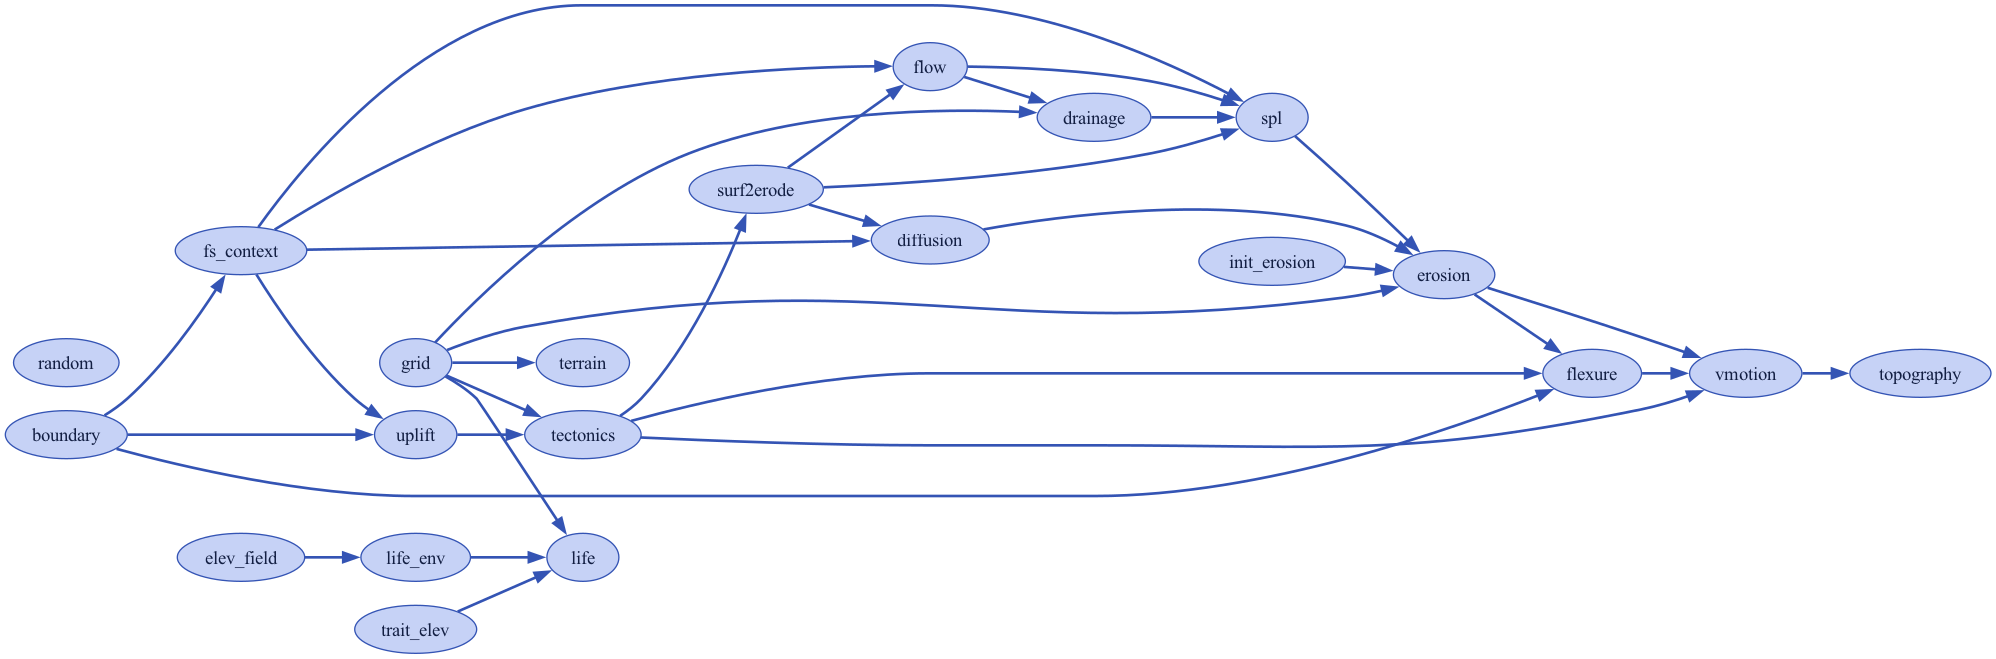

In [3]:
adascape_model.visualize()

Second we will define the parameters of the simulation and in particular an **island** that starts at uniform elevation **h0** and has a **boundary** that prevents dispersal of organisms outside the island.

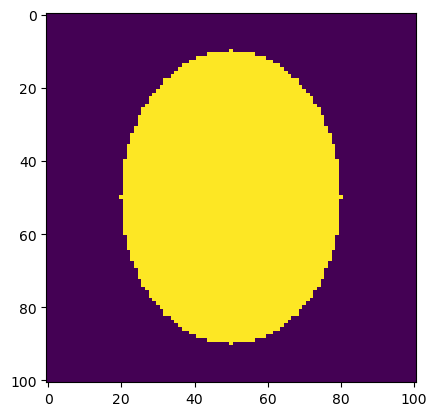

In [4]:
clk = np.linspace(0, 25e6, 1001)
nx, ny = 101, 101
lx, ly = 1e5, 1e5
h0 = 1500

xx, yy = np.meshgrid(np.linspace(0,lx, nx), np.linspace(0,ly,ny))
island = np.where((((xx - 5e4) / (3e4)) ** 2 + ((yy - 5e4) / (4e4)) ** 2 <= 1),1,0)
boundary = np.column_stack([xx[island.astype('bool')], yy[island.astype('bool')]])

island = xr.DataArray(island, dims=('y', 'x'))

random_seed = 12345
plt.imshow(island)

In comparion with the previous example, the setup of this island model considers that erosion only occurs in this plateau-like island and that the individuals cannot disperse outside the island boundary. 
```python
    'spl__k_coef': h0*2.5e-7
    'life__disp_boundary': xr.DataArray(boundary, dims=('p', 'd'))
```
Also we assume that innitial population arrived from the west
```python
    'life__init_x_range_min':  0.35*lx,
    'life__init_x_range_max':  0.65*lx,
    'life__init_y_range_min':  0.35*ly,
    'life__init_y_range_max':  0.65*ly
```


In [5]:
# %create_setup adascape_model --default --verbose
import xsimlab as xs

ds_in = xs.create_setup(
    model=adascape_model,
    clocks={'time':clk,
            'out':clk[::10]},
     master_clock='time',
    input_vars={
        # nb. of grid nodes in (y, x)
        'grid__shape': [ny, nx],
        # total grid length in (y, x)
        'grid__length': [ly, lx],
        # node status at borders
        'boundary__status': 'fixed_value',
        # uplift rate
        'uplift__rate': 0,
        # bedrock channel incision coefficient
        'spl__k_coef': island*3.0e-7,
        # drainage area exponent
        'spl__area_exp': 0.4,
        # slope exponent
        'spl__slope_exp': 1,
        # diffusivity (transport coefficient)
        'diffusion__diffusivity': 1e-2,
        # lithospheric rock density
        'flexure__lithos_density': 2600,
        # asthenospheric rock density
        'flexure__asthen_density': 3200,
        # effective elastic plate thickness
        'flexure__e_thickness': 5e4,
        # surface topography elevation
        'topography__elevation': (island*h0) + np.random.random((ny, nx)),
        # min initial trait value
        'trait_elev__init_trait_min': 0.75,
        # max initial trait value
        'trait_elev__init_trait_max': 0.75,
        # slope of opt. trait vs. elevation linear relationship
        'trait_elev__lin_slope': 0.95,
        # min elevation value for normalization
        'trait_elev__norm_min': 1,
        # max elevation value for normalization
        'trait_elev__norm_max': 2000,
        # initial number of individuals
        'life__init_abundance': 100,
        # random number generator seed
        'life__random_seed': random_seed,
        # threshold used to construct taxon clusters
        'life__taxon_threshold': 0.05,
        # Taxon definition based on common ancestry and traits ('traits') or common ancestry,
        # traits and location ('traits_location')
        'life__taxon_def': 'traits',
        # min range of individuals on x coordinate
        'life__init_x_range_min':  0.20*lx,
        # min range of individuals on x coordinate
        'life__init_x_range_max':  0.30*lx,
        # min range of individuals on y coordinate
        'life__init_y_range_min':  0.40*ly,
        # min range of individuals on y coordinate
        'life__init_y_range_max':  0.60*ly,
        # dispersal boundaries as an xr.DataArray with vertices [[x,y],...] of bounded area
        # with dimensions p and d
        'life__disp_boundary': xr.DataArray(boundary, dims=('p', 'd')),
        # Correlation coefficient between traits, 0 means that traits are independent, where a
        # value of rho different from 0 and between -1 and 1, will determine the degree of
        # correlation betweentraits for all individuals
        'life__rho': 0,
        # trait mediated competition for a limiting resource, where the degree of trait
        # similarity is given by this parameter. If its value is =>1 all individuals in the
        # local neighbourhood are counted, but if its values is < 1 then only those
        # individuals with similar trait values are counted.
        'life__sigma_u': 0.2,
        # environmental fitness selectivity or width around optimal traitvalue for each
        # individual's trait
        'life__sigma_f': 0.25,
        # dispersal variability in spatial units
        'life__sigma_d': 10e3,
        # trait variability of mutated offspring
        'life__sigma_m': 0.05,
        # mutation probability
        'life__p_m': 0.005,
        # fixed neighborhood radius
        'life__r': 2.0e4,
        # carrying capacity within a neighborhood
        'life__K': 50,
        # random number generator seed
        'random__seed': random_seed,
    },
    output_vars={'topography__elevation': 'out',
                 'flow__basin': 'out',
                 'grid__cell_area': 'out',
                 'life__x': 'out',
                 'life__y': 'out',
                 'life__traits': 'out',
                 'life__taxon_id': 'out',
                 'life__ancestor_id': 'out'}
)

/Users/acevedo/mambaforge/envs/adascape_dev/lib/python3.12/site-packages/xsimlab/xr_accessor.py:229: FutureWarning: variable 'time' with name matching its dimension will not be automatically converted into an `IndexVariable` object in the future.
  xr_var = as_variable(data, name=dim)
/Users/acevedo/mambaforge/envs/adascape_dev/lib/python3.12/site-packages/xsimlab/xr_accessor.py:229: FutureWarning: variable 'out' with name matching its dimension will not be automatically converted into an `IndexVariable` object in the future.
  xr_var = as_variable(data, name=dim)


In [ ]:
with xs.monitoring.ProgressBar():
    ds_out = ds_in.xsimlab.run(model=adascape_model)                   

             0% | initialize 

/Users/acevedo/mambaforge/envs/adascape_dev/lib/python3.12/site-packages/xsimlab/drivers.py:338: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for step, (_, ds_step) in enumerate(ds_gby_steps):


In [ ]:
dtf = ext.get_dataframe(ds_out, out_vars=['life__taxon_id', 'life__ancestor_id',
                                'life__trait_elev', 'life__y', 'life__x'])

In [ ]:
time_sel = np.arange(0,26e6, 5e6)
ext.plot_topo_taxa(ds_out, dtf, time_sel)

In [ ]:
tree = dtf.rename(columns={'out':'time'}).ptree.to_dendropy_tree()
tree.print_plot()